# Working with time series

The hope for this project is to practice using time series using three different approaches - ARIMA time series Analysis, Bayesian time series, and LSTM (hopefully in fastai - may have to be configured separately since it runs on a GPU). 

#### Import libraries

In [1]:
#MCMC/ARIMA packages
import pymc3 as pm
import pmdarima as ar
import arviz as az
from statsmodels.tsa.stattools import adfuller

#plotting
import seaborn as sns
import matplotlib.pyplot as plt

#data wrangling
import pandas as pd
import numpy as np

This is just monthly stock trend data for Salesforce (CRM), obtained from yahoo https://finance.yahoo.com/quote/crm/history/

In [2]:
CRM = pd.read_csv('data/CRM_daily.csv', index_col='Date',parse_dates=True)

In [3]:
CRM.head(12)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-06-23,3.7500,4.3250,3.6875,4.3000,4.3000,43574400
2004-06-24,4.3875,4.4225,4.1250,4.1900,4.1900,8887200
2004-06-25,4.1275,4.1875,3.9475,3.9500,3.9500,6710000
2004-06-28,4.0000,4.0525,3.8600,4.0000,4.0000,2270800
2004-06-29,4.0000,4.1750,3.9575,4.1000,4.1000,2112000
2004-06-30,4.1000,4.2350,4.0075,4.0175,4.0175,2087600
2004-07-01,4.0200,4.0500,3.9750,4.0075,4.0075,1754800
2004-07-02,4.0250,4.2450,4.0125,4.2450,4.2450,993200
2004-07-06,4.2325,4.2500,4.1200,4.2500,4.2500,1216800


In [4]:
CRM.shape

(4441, 6)

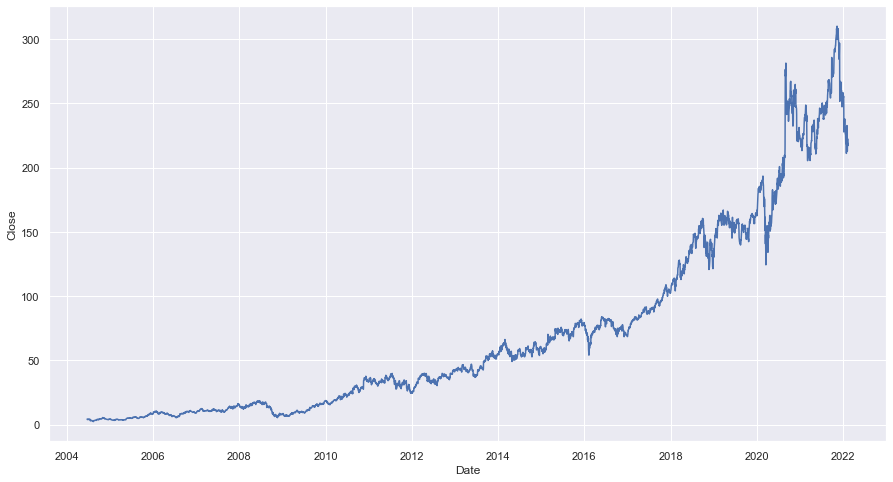

In [5]:
sns.set_theme()
sns.set(rc = {'figure.figsize':(15,8)})
p1 = sns.lineplot(
    data = CRM,
    x = "Date", y = "Close"
)

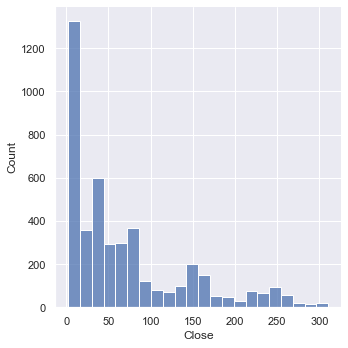

In [6]:
sns.displot(data = CRM, x="Close", binwidth = 14)

Closing price is non-normally distributed and trend is non-stationary, which is also confirmed below.

#### Stationarity Check (Dickey Fuller)

In [7]:
ts_test = adfuller(CRM['Close'], autolag = 'AIC')
ts_test

(-0.06392047117515172,
 0.9529157133939834,
 31,
 4409,
 {'1%': -3.4318340352231185,
  '5%': -2.862195763748743,
  '10%': -2.567119067159428},
 19606.741882699625)

#### Transformation using differences

In [8]:
CRM_stnry = CRM.diff().dropna(); CRM_stnry.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-06-24,0.6375,0.0975,0.4375,-0.1100,-0.1100,-34687200.0
2004-06-25,-0.2600,-0.2350,-0.1775,-0.2400,-0.2400,-2177200.0
2004-06-28,-0.1275,-0.1350,-0.0875,0.0500,0.0500,-4439200.0
2004-06-29,0.0000,0.1225,0.0975,0.1000,0.1000,-158800.0
2004-06-30,0.1000,0.0600,0.0500,-0.0825,-0.0825,-24400.0


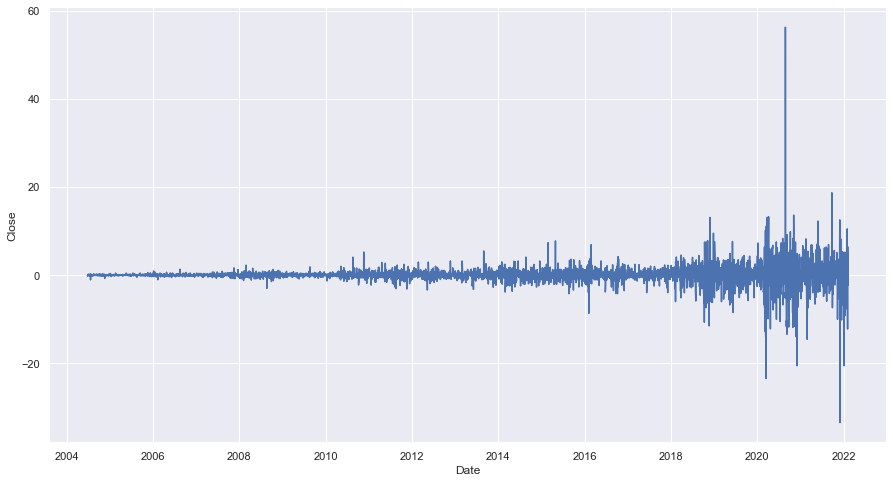

In [9]:
sns.set_theme()
sns.set(rc = {'figure.figsize':(15,8)})
p1 = sns.lineplot(
    data = CRM_stnry,
    x = "Date", y = "Close"
)

In [10]:
ts_test2 = adfuller(CRM_stnry['Close'], autolag = 'AIC')
ts_test2

(-11.284501171020382,
 1.429095098541365e-20,
 30,
 4409,
 {'1%': -3.4318340352231185,
  '5%': -2.862195763748743,
  '10%': -2.567119067159428},
 19601.313864077012)

Data is now stationary based on the ADF test

#### Modeling